In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy, implicit
print("SciPy:", scipy.__version__)
print("implicit:", implicit.__version__)

/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SciPy: 1.11.3
implicit: 0.7.2


In [2]:
usr = pd.read_csv('data/user_ratings.csv')
usr.head()

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


In [3]:
ratings_per_users = usr.groupby('Username').size()
ratings_per_movies = usr.groupby('BGGId').size()

<Axes: >

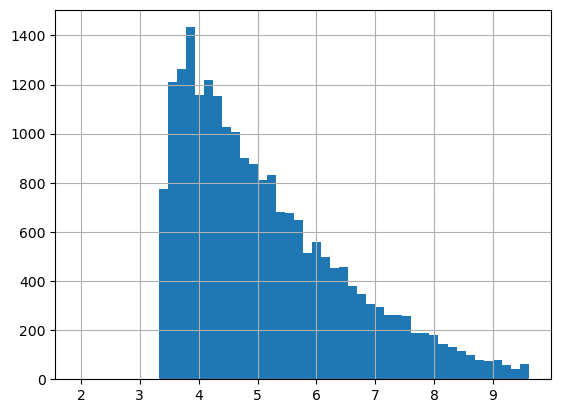

In [4]:
import numpy as np
#remove outliers
pctl_99 = ratings_per_movies.quantile(0.99)

np.log(ratings_per_movies[ratings_per_movies < pctl_99]).hist(bins=50)

In [5]:
usr['MappedRating'] = np.where(usr['Rating'] <= 4, -1,
                       np.where(usr['Rating'] <= 7, 0, 1))

In [6]:
usr.groupby('MappedRating').size() 

MappedRating
-1    1001738
 0    9374387
 1    8566090
dtype: int64

In [7]:
ratings_per_users.median(), ratings_per_movies.median()

(12.0, 125.0)

<Axes: >

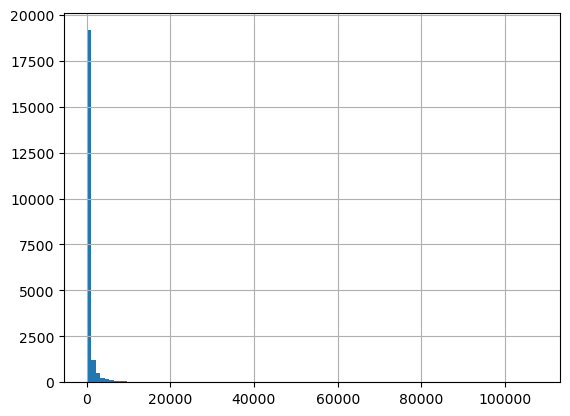

In [8]:
ratings_per_movies.hist(bins = 100)

In [9]:
keep = ratings_per_users[ratings_per_users >= 5].index
usr = usr[usr['Username'].isin(keep)]

<Axes: >

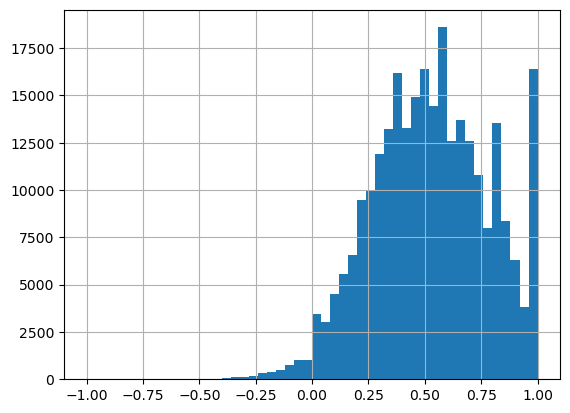

In [10]:
usr.groupby('Username')['MappedRating'].mean().hist(bins=50)


In [11]:
user_map = {u: i for i, u in enumerate(usr['Username'].unique())}
game_map = {g: j for j, g in enumerate(usr['BGGId'].unique())}

rows = usr['Username'].map(user_map)
cols = usr['BGGId'].map(game_map)

rows.shape

(18696365,)

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from implicit.als import AlternatingLeastSquares

def create_A_matrix(users, items, ratings):
    user_map = {user: i for i, user in enumerate(users.unique())}
    item_map = {item: i for i, item in enumerate(items.unique())}
    rows = users.map(user_map)
    cols = items.map(item_map)

    #mask = ratings.notna()
    A = coo_matrix((ratings, (rows,cols)), shape=(len(user_map), len(item_map)))

    return A, user_map, item_map


A, user_map, item_map = create_A_matrix(usr['Username'], usr['BGGId'], usr['Rating'])
rows, cols, data = A.row, A.col, A.data
indices = np.arange(len(data))
train, test = train_test_split(indices, test_size=0.05, random_state=42)

train_rows, train_cols, train_data = rows[train], cols[train], data[train]
#val_rows, val_cols, val_data = rows[test_index], cols[test_index], data[test_index]

A_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)


In [14]:
def als(R, k=2, W= None, lambda_=0.1, n_iters=10 ):
    m, n = R.shape

    #Global mean
    mu = R.data.mean()
    
    # Initialize parameters
    U = np.random.normal(scale=1./k, size=(m, k))
    V = np.random.normal(scale=1./k, size=(n, k))
    b_user = np.zeros(m)
    b_item = np.zeros(n)

    #create two versions for row and column operations
    R_csr = R.tocsr()
    R_csc = R.tocsc()


    if W is None:
        W = csr_matrix(R_csr.copy())
        W.data[:] = 1.0
    W_csr = W.tocsr()
    W_csc = W.tocsc()

    nonzero_users = np.unique(R_csr.nonzero()[0])
    nonzero_items = np.unique(R_csc.nonzero()[1])
    for _ in range(n_iters):
        #print(f'Iteration {_+1}/{n_iters}')
        # Update user features
        for i in nonzero_users:
            start, end = R_csr.indptr[i], R_csr.indptr[i+1]
            idx  = R_csr.indices[start:end]
            r_i = R_csr.data[start:end] 
            w_i = W_csr.data[start:end]
            if len(idx) > 0:
                V_i = V[idx, :]
                W_i = np.diag(w_i)
                r_i_centered = r_i - mu - b_user[i] - b_item[idx]
                A = V_i.T @ W_i @ V_i + lambda_ * np.eye(k)
                b = V_i.T @ (W_i @ r_i_centered)
                U[i] = np.linalg.solve(A,b)

                #update user bias
                pred = V_i @ U[i]
                b_user[i] = np.average(r_i - pred - mu - b_item[idx], weights = w_i)

        # Update item features
        for j in nonzero_items:
            start, end = R_csc.indptr[j], R_csc.indptr[j+1]
            idx  = R_csc.indices[start:end]            
            r_j = R_csc.data[start:end]
            w_j = W_csc.data[start:end]
            if len(idx) > 0:
                U_j = U[idx,:]
                W_j = np.diag(w_j)
                r_j_centered = r_j - mu - b_user[idx] - b_item[j]
                A = U_j.T @  W_j @ U_j + lambda_ * np.eye(k)
                b = U_j.T @ (W_j @ r_j_centered)
                V[j] = np.linalg.solve(A,b)

                #udate item bias    
                pred = U_j @ V[j]
                b_item[j] = np.average(r_j - pred - mu - b_user[idx], weights = w_j)
    return U, V, b_user, b_item, mu

In [15]:

from sklearn.model_selection import KFold
from implicit.als import AlternatingLeastSquares 

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


import numpy as np

def recall_at_k(U, V, A_train, A_val, k=10, batch_size=512, verbose=False):
    """
    Compute Recall@K for validation set A_val given factor matrices U, V,
    and training matrix A_train (for masking), using batched scoring.
    """
    A_train_csr = A_train.tocsr()
    A_val_csr = A_val.tocsr()
    n_users = A_val.shape[0]
    recalls = []

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        if verbose and start % (batch_size * 10) == 0:
            print(f"Processing users {start}-{end} / {n_users}")

        # batch of users
        U_batch = U[start:end]                      # (batch_size, k)
        scores_batch = U_batch @ V.T                # (batch_size, n_items)

        # mask training items for each user
        for i, u in enumerate(range(start, end)):
            train_items = A_train_csr[u].indices
            if len(train_items) > 0:
                scores_batch[i, train_items] = -np.inf

        # compute recall for each user in the batch
        for i, u in enumerate(range(start, end)):
            val_items = A_val_csr[u].indices
            if len(val_items) == 0:
                continue
            topk = np.argpartition(scores_batch[i], -k)[-k:]
            recall = len(np.intersect1d(val_items, topk)) / len(val_items)
            recalls.append(recall)

    return np.mean(recalls) if recalls else np.nan


def recall_at_k_implicit(U, V, P_train, P_val, k=10, batch_size=512, verbose=False):
    """
    Compute Recall@K for implicit ALS factors, using batched scoring.
    """
    csr_train, csr_val = P_train.tocsr(), P_val.tocsr()
    n_users = U.shape[0]
    recalls = []

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        if verbose and start % (batch_size * 10) == 0:
            print(f"Processing users {start}-{end} / {n_users}")

        # batch scoring
        U_batch = U[start:end]
        scores_batch = U_batch @ V.T

        # mask known positives
        for i, u in enumerate(range(start, end)):
            train_items = csr_train[u].indices
            if len(train_items) > 0:
                scores_batch[i, train_items] = -np.inf

        # compute per-user recall
        for i, u in enumerate(range(start, end)):
            val_items = csr_val[u].indices
            if len(val_items) == 0:
                continue
            topk = np.argpartition(scores_batch[i], -k)[-k:]
            recall = len(np.intersect1d(val_items, topk)) / len(val_items)
            recalls.append(recall)

    return np.mean(recalls) if recalls else np.nan

def precision_at_k(U, V,A_val, k=10, verbose=False):
    precisions = []

    VT = V.T
    val_items = np.unique(A_val.col)

    for u in range(U.shape[0]):
        if u % 1000 == 0 and verbose:
            print(f'Processing user {u}/{U.shape[0]}')
        row = A_val.getrow(u).tocoo()
        if row.nnz < 2: # skip users with less than 2 ratings, 1 rating is useless for precision
            continue
        y_true = row.col[row.data > 0] # liked items
        if len(y_true) == 0:
            continue
        y_scores = U[u, :] @ VT[:,val_items]
        topkidx = np.argpartition(-y_scores, k)[:k] #efficient lookup of top k indices
        y_pred = val_items[topkidx[np.argsort(-y_scores[topkidx])]]  # top-k items

        hits = np.intersect1d(y_true, y_pred) # how many of the true liked items are in the top-k predictions
        precision = len(hits) / k # fraction of hits that were in the top 10 predictions
        precisions.append(precision)
        
    return -np.mean(precisions) if precisions else np.nan
    

def cv_als(A, k=5,W=None, als_params = {'k':20, 'lambda':0.1, 'n_iters':10, 'alpha':15} ):

    rmses = []
    recalls = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    rows, cols, data = A.row, A.col, A.data
    #indices = np.arange(len(data))
    indices = np.arange(len(data))

    for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
        #print("TRAIN:", train_index, "TEST:", test_index)

        train_rows, train_cols, train_data = rows[train_idx], cols[train_idx], data[train_idx]
        val_rows, val_cols, val_data = rows[val_idx], cols[val_idx], data[val_idx]

        A_fold_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)
        A_fold_val = coo_matrix((val_data, (val_rows, val_cols)), shape=A.shape)
        
        # Train your model on A_train here
         # train implicit ALS
        model = AlternatingLeastSquares(
            factors=als_params['k'],
            regularization=als_params['lambda'],
            iterations=als_params['n_iters'],
            num_threads=8
        )
        model.fit(A_fold_train)

        U, V = model.user_factors, model.item_factors



        # Evaluate your model on A_test here
        #A_pred = U @ V.T
        # Compute RMSE on the test set
        #print(f"Fold {fold+1}")
        #print(U.shape, V.shape)
        #test values
        y_test = A_fold_val.data

        #get predictions from the predicted matrix
        latent_pred = np.einsum('ij,ij->i', U[A_fold_val.row], V[A_fold_val.col])

        b_user = np.zeros(A.shape[0])
        b_item = np.zeros(A.shape[1])
        mu = A_fold_train.data.mean()
        

        #add biases and global mean
        y_pred = mu + b_user[A_fold_val.row] + b_item[A_fold_val.col] + latent_pred
        r_at_k = recall_at_k(U, V,A_fold_train, A_fold_val, k=10)
        rmse_ = rmse(y_test, y_pred)
        rmses.append(rmse_)
        recalls.append(r_at_k)

    return np.mean(rmses), np.mean(recalls)


def cv_als_implicit(A, n_splits=5, als_params={'k':20, 'lambda':0.1, 'n_iters':10, 'alpha':15}):
    """
    Cross-validation for implicit ALS using user-level splits.
    Returns mean Recall@10 across folds.
    """
    recalls = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rows, cols, data = A.row, A.col, A.data
    users = np.arange(A.shape[0])

    for fold, (train_users, val_users) in enumerate(kf.split(users)):
        print(f"Fold {fold+1}/{n_splits}")

        # mask by users
        train_mask = np.isin(rows, train_users)
        val_mask   = np.isin(rows, val_users)

        train_rows, train_cols, train_data = rows[train_mask], cols[train_mask], data[train_mask]
        val_rows, val_cols, val_data       = rows[val_mask],   cols[val_mask],   data[val_mask]

        A_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)
        A_val   = coo_matrix((val_data,   (val_rows,   val_cols)),   shape=A.shape)

        # confidence matrix: C = 1 + alpha * R
        C = (A_train * als_params['alpha']).astype(np.float32).tocsr()
        C.data = 1 + C.data

        # train implicit ALS
        model = AlternatingLeastSquares(
            factors=als_params['k'],
            regularization=als_params['lambda'],
            iterations=als_params['n_iters'],
            num_threads=8
        )
        model.fit(C)

        # evaluate Recall@10
        U, V = model.user_factors, model.item_factors
        r_at_k = recall_at_k_implicit(U, V, A_train, A_val, k=10, batch_size=1024)
        print(f"Recall@10 = {r_at_k:.4f}")
        recalls.append(r_at_k)

    return np.nanmean(recalls)


def make_holdout_split(P, val_franction = 0.2, seed=42):
    np.random.seed(seed)

    csr = P.tocsr()
    rows_t, cols_t, data_t = [], [], []
    rows_v, cols_v, data_v = [], [], []

    for u in range(P.shape[0]):
        items = csr[u].indices
        n_items = len(items)
        if n_items == 0:
            continue    

        n_val = max(1, int(n_items * val_franction))
        val_indices = np.random.choice(items, size=n_val, replace=False)
        train_indices = np.setdiff1d(items, val_indices)

        vals = csr[u].data
        train_mask = np.isin(items, train_indices)
        val_mask = np.isin(items, val_indices)

        rows_t += [u] * np.sum(train_mask)
        cols_t += items[train_mask].tolist()
        data_t += vals[train_mask].tolist()
        rows_v += [u] * np.sum(val_mask)
        cols_v += items[val_mask].tolist()
        data_v += vals[val_mask].tolist()

    P_train = coo_matrix((data_t, (rows_t, cols_t)), shape=P.shape).tocsr()
    P_val = coo_matrix((data_v, (rows_v, cols_v)), shape=P.shape).tocsr()
    return P_train, P_val



In [16]:
def weight_matrix(weight_dict, A):
    W = csr_matrix(A.copy())
    W.data = np.array([weight_dict.get(rating, 1.0) for rating in A.data])
    return W

In [16]:
mask_active_users = np.bincount(A.row) > 50
keep_users = np.where(mask_active_users)[0]
A_filtered = A.tocsr()[keep_users, :].tocoo()

# Fraction of boardgames still present
item_counts_before = np.bincount(A.col)
item_counts_after = np.bincount(A_filtered.col, minlength=A.shape[1])
kept_fraction = np.count_nonzero(item_counts_after) / np.count_nonzero(item_counts_before)
print(f"{kept_fraction:.2%} of boardgames remain after filtering users >50 reviews")

100.00% of boardgames remain after filtering users >50 reviews


In [ ]:
# grid search for hyperparameter tuning
import random 
np.random.seed(42)
import itertools
import time 

k_values = [16,24,32,48]
lambda_values = [0.001, 0.01, 0.1, 1.0]
n_iters_values = [10,20]
best_score = -np.inf
weights_dicts = [{-1: 1.0, 0: 0.5, 1: 2.0}, 
                 {-1: 1.0, 0: 1.0, 1: 1.0}, {-1: 1.5, 0: 0.5, 1:1.5} ,
                 {-1: 2.0, 0: 0.5, 1: 1.0}]
alphas = [1,10,20]
best_params = None
results = []
keep = ratings_per_users[ratings_per_users >= 50].index

sample_user_indices = [user_map[u] for u in keep.unique()]

# For faster computation during hyperparameter tuning, we can sample a subset of users
A_small = A_train.tocsr()[sample_user_indices, :].tocoo()

R = A_small.copy()
R.data = np.where(R.data > 0, 1.0, 0.0)  # implicit feedback: liked or not
grid = random.sample(list(itertools.product(k_values, lambda_values, n_iters_values, alphas)) , 20)

# Grid search loop
for k, lambda_, n_iters, alpha in grid:
    print(f"\nEvaluating for k={k}, lambda={lambda_}, n_iters={n_iters}, alpha={alpha}")
    t0 = time.time()

    recall = cv_als_implicit(
        R,
        n_splits=3,
        als_params={'k': k, 'lambda': lambda_, 'n_iters': n_iters, 'alpha': alpha}
    )

    runtime_min = (time.time() - t0) / 60
    print(f"Average Recall@10: {recall:.4f} (took {runtime_min:.2f} min)")

    results.append({'k': k, 'lambda': lambda_, 'n_iters': n_iters, 'alpha': alpha,
                    'recall': recall, 'runtime_min': runtime_min})

    if recall > best_score:
        best_score = recall
        best_params = (k, lambda_, n_iters, alpha)

print(f"\nBest params: k={best_params[0]}, lambda={best_params[1]}, n_iters={best_params[2]}, "
      f"alpha={best_params[3]} with Recall@10={best_score:.4f}")

results_df = pd.DataFrame(results).sort_values('recall', ascending=False)


Evaluating for k=32, lambda=0.1, n_iters=20, alpha=20
Fold 1/3


/Users/khallberg/anaconda3/lib/python3.13/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 = 0.0001
Fold 2/3


  0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 = 0.0001
Fold 3/3


  0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 = 0.0001
Average Recall@10: 0.0001 (took 4.30 min)

Evaluating for k=24, lambda=0.1, n_iters=20, alpha=1
Fold 1/3


  0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 = 0.0001
Fold 2/3


  0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 = 0.0001
Fold 3/3


  0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 = 0.0001
Average Recall@10: 0.0001 (took 6.28 min)

Evaluating for k=48, lambda=0.01, n_iters=20, alpha=10
Fold 1/3


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [111]:
# fit A_train with best hyperparameters
best_k, best_lambda, best_n_iters, best_weights = best_params
W_final = weight_matrix(best_weights, A_train)
U_final, V_final, b_user_final, b_item_final, mu_final = als(A_train, k=best_k, W=W_final, lambda_=best_lambda, n_iters=best_n_iters)





KeyboardInterrupt: 

In [44]:
U_final, V_final, b_user_final, b_item_final, mu_final

(array([[-0.29061476,  0.03920548, -0.08668655, ..., -0.00836776,
          0.43082194,  0.36472493],
        [-0.33340123,  0.06685874,  0.00620702, ...,  0.11551329,
          0.52634272,  0.07712662],
        [-0.8875549 ,  0.46659656, -0.2727209 , ..., -0.06316011,
         -0.70611347,  0.34176356],
        ...,
        [-0.13365827,  0.30773037,  0.36670747, ..., -0.54964161,
          0.61790655, -0.09876183],
        [ 0.18394706,  0.11112714,  0.18108959, ...,  0.10457707,
         -0.02166364, -0.02672265],
        [-0.0055203 , -0.00247424, -0.21409891, ..., -0.03280549,
         -0.03862254, -0.00863803]]),
 array([[-0.56435885, -0.31291041, -0.06386863, ...,  0.58644677,
          0.06293163, -0.3186212 ],
        [-0.48795639, -1.00846113,  0.65096434, ...,  0.83310959,
          1.01944136, -0.08378763],
        [ 0.08356304,  0.02406257,  0.22706407, ..., -0.40957938,
          0.19492714,  0.06713397],
        ...,
        [ 0.23710575, -0.38744528,  0.77335729, ..., -

In [87]:
A_test.shape

(272184, 21925)

In [61]:
def build_confidence_matrix(R, alpha = 20, r_min = 1, r_max = 10, gamma = 1.0):
    R_scaled = R.copy().astype(np.float32)
    R_scaled.data = np.clip((R_scaled.data - r_min) / (r_max - r_min), 0, 1)
    if gamma != 1.0:
        R_scaled.data = R_scaled.data ** gamma

    C = R_scaled.tocsr()
    C.data = 1 + alpha * C.data
    return C 

In [ ]:
# grid search for hyperparameter tuning
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k , precision_at_k, ranking_metrics_at_k, leave_k_out_split
import random 
np.random.seed(42)
import itertools
import time 

k_values = [32,64, 128]
lambda_values = [0.0001, 0.01, 1.0]
n_iters_values = [20]
best_score = -np.inf
alphas = [50, 100]
gammas = [1.0,2.0]
best_params = None
results = []
keep = ratings_per_users[ratings_per_users >= 10].index

sample_user_indices = [user_map[u] for u in keep.unique()]

# For faster computation during hyperparameter tuning, we can sample a subset of users
R = A_train.tocsr()[sample_user_indices, :].tocoo()

#R.data = np.where(R.data > 0, 1.0, 0.0)  # implicit feedback: liked or not
grid = random.sample(list(itertools.product(k_values, lambda_values, n_iters_values, alphas)) , 20)

results = []
# Grid search loop
for k, lambda_, n_iters, alpha in grid:
    print(f"\nEvaluating for k={k}, lambda={lambda_}, n_iters={n_iters}, alpha={alpha}")
    t0 = time.time()
    map_at_ks = []
    ndcg_ks = []
    precision_ks = []
    ranking_ks = []
    for seed in range(3):
        train, val = leave_k_out_split(R, K=1, random_state=42+seed)
        model = AlternatingLeastSquares(factors = k,
                                        regularization=lambda_,
                                        iterations=n_iters)
        C = build_confidence_matrix(train, alpha=alpha)
        model.fit(C.T)
        ranking_k = ranking_metrics_at_k(model, train.T, val.T, K=10)
        map_at_ks.append(ranking_k['map'])
        ndcg_ks.append(ranking_k['ndcg'])
        precision_ks.append(ranking_k['precision'])
    
    results.append({'k': k, 'lambda': lambda_, 'n_iters': n_iters, 'alpha': alpha, 'map_at_10': np.mean(map_at_ks),
                    'ndcg_at_10': np.mean(ndcg_ks), 'precision_at_10': np.mean(precision_ks),
                    'runtime_min': (time.time() - t0) / 60})
    print(f"Mean MAP@10: {np.mean(map_at_ks):.4f}, NDCG@10: {np.mean(ndcg_ks):.4f}, Precision@10: {np.mean(precision_ks):.4f} (took {(time.time() - t0) / 60:.2f} min)")

results_df = pd.DataFrame(results).sort_values('map_at_10', ascending=False)


        


Evaluating for k=32, lambda=0.01, n_iters=20, alpha=10


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2981069087982178 seconds
  warnings.warn(
100%|██████████| 14502/14502 [00:08<00:00, 1774.77it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2964751720428467 seconds
  warnings.warn(
100%|██████████| 14519/14519 [00:08<00:00, 1734.28it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3023688793182373 seconds
  warnings.warn(
100%|██████████| 14497/14497 [00:08<00:00, 1796.69it/s]


Mean MAP@10: 0.0009, NDCG@10: 0.0020, Precision@10: 0.0034 (took 10.02 min)

Evaluating for k=32, lambda=0.001, n_iters=10, alpha=1


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3025798797607422 seconds
  warnings.warn(
100%|██████████| 14572/14572 [00:08<00:00, 1713.04it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3089771270751953 seconds
  warnings.warn(
100%|██████████| 14463/14463 [00:08<00:00, 1784.07it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.29596590995788574 seconds
  warnings.warn(
100%|██████████| 14476/14476 [00:08<00:00, 1734.74it/s]


Mean MAP@10: 0.0006, NDCG@10: 0.0015, Precision@10: 0.0027 (took 5.47 min)

Evaluating for k=24, lambda=0.001, n_iters=20, alpha=20


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2968790531158447 seconds
  warnings.warn(
100%|██████████| 14439/14439 [00:09<00:00, 1463.80it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.30200982093811035 seconds
  warnings.warn(
100%|██████████| 14481/14481 [00:07<00:00, 1832.27it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3239753246307373 seconds
  warnings.warn(
 20%|██        | 4/20 [00:49<03:17, 12.37s/it]


KeyboardInterrupt: 

In [55]:
k_values = [16,32,64]
lambda_values = [0.0001, 0.01, 1.0]
n_iters_values = [20]
best_score = -np.inf
alphas = [50, 100]
gammas = [1.0,2.0]

from implicit.nearest_neighbours import bm25_weight

# Re-weight implicit feedback

train, val = leave_k_out_split(R, K=5, random_state=42+seed)

X = bm25_weight(train, K1=1.2, B=0.75)

results = []
param_grid = [
    (128, 0.01, 25, 160, 3.0),
    (128, 0.03, 25, 160, 3.0),
    (128, 0.01, 25, 200, 3.0),
    (128, 0.01, 25, 160, 4.0),
    (192, 0.01, 20, 160, 3.0),
    (192, 0.03, 20, 160, 3.0),
    (192, 0.01, 20, 200, 3.0),
    (256, 0.03, 20, 160, 3.0),
    (256, 0.03, 20, 200, 3.0),
    (128, 0.01, 20, 160, 3.0)  # cg_steps=4
]

for k, lambda_, n_iters, alpha, gamma in param_grid:
    print(f"Evaluating k={k}, λ={lambda_}, iters={n_iters}, α={alpha}, gamma={gamma}")
    C = build_confidence_matrix(X, alpha=alpha, gamma = gamma)
    model = AlternatingLeastSquares(factors=k,
                                    regularization=lambda_,
                                    iterations=n_iters,
                                    random_state=42)
    model.fit(C.T)

    # Evaluation (user×item)
    train_ui = train.T.tocsr().astype(np.float32)
    val_ui   = val.T.tocsr().astype(np.float32)
    ranking_k = ranking_metrics_at_k(model, train_ui, val_ui, K=10)
    results.append((k, lambda_, n_iters, alpha,gamma, ranking_k['precision'], ranking_k['ndcg'], ranking_k['map']))

results_df = pd.DataFrame(results, columns = ['k','lambda','n_iters','alpha','gamma','precision@K','NDCG@K','MAP@K']).sort_values('MAP@K', ascending=False)


Evaluating k=128, λ=0.01, iters=25, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.28827714920043945 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:16<00:00, 1283.39it/s]


Evaluating k=128, λ=0.03, iters=25, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.25895190238952637 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:17<00:00, 1199.91it/s]


Evaluating k=128, λ=0.01, iters=25, α=200, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2386307716369629 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:18<00:00, 1130.79it/s]


Evaluating k=128, λ=0.01, iters=25, α=160, gamma=4.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2721128463745117 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:19<00:00, 1080.84it/s]


Evaluating k=192, λ=0.01, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2093970775604248 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:20<00:00, 996.42it/s] 


Evaluating k=192, λ=0.03, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2700321674346924 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:20<00:00, 993.60it/s] 


Evaluating k=192, λ=0.01, iters=20, α=200, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.21461892127990723 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:20<00:00, 1014.51it/s]


Evaluating k=256, λ=0.03, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2624948024749756 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:23<00:00, 879.86it/s]


Evaluating k=256, λ=0.03, iters=20, α=200, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2097012996673584 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:22<00:00, 900.18it/s]


Evaluating k=128, λ=0.01, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.23885083198547363 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:17<00:00, 1145.71it/s]


In [62]:
best_k, best_lambda, best_n_iters, best_alpha, best_gamma = 256, 0.03, 25, 160, 3.0

A_test = coo_matrix((data[test], (rows[test], cols[test])), shape=A.shape)

X = bm25_weight(A_train, K1=1.2, B=0.75)

C_final = build_confidence_matrix(X, alpha=best_alpha, gamma=best_gamma)
model_final = AlternatingLeastSquares(factors=best_k,
                                      regularization=best_lambda,
                                      iterations=best_n_iters,
                                      random_state=42)
model_final.fit(C_final.T)
U_final_implicit, V_final_implicit = model_final.user_factors, model_final.item_factors

#validate on test
ranking = ranking_metrics_at_k(model_final, A_train.T.tocsr().astype(np.float32), A_test.T.tocsr().astype(np.float32), K=10)



/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.17931699752807617 seconds
  warnings.warn(
100%|██████████| 21036/21036 [00:24<00:00, 846.65it/s]


In [ ]:
def fold_in_implicit_user(V, liked_items, alpha=5, lambda_=0.03):
    """
    Compute a new user vector given items they've liked (implicit feedback).
    """
    V_i = V[liked_items]
    # confidence weights
    C_i = 1 + alpha * np.ones(len(liked_items), dtype=np.float32)
    
    A = V_i.T @ (C_i[:, None] * V_i) + lambda_ * np.eye(V.shape[1])
    b = V_i.T @ (C_i * np.ones(len(liked_items), dtype=np.float32))
    
    u_new = np.linalg.solve(A, b)
    return u_new

def recommend_new_user(V, liked_items,alpha=5, lambda_=0.03):
    u = fold_in_implicit_user(V,liked_items=liked_items, alpha=alpha, lambda_=lambda_)

    #calculate scores
    scores = V.dot(u)

    #normalize between 0 and 1 
    scores = (scores - min(scores)) / (max(scores) - min(scores))

    return scores 





In [84]:
liked_items = np.array([25, 122, 562])
scores = recommend_new_user(V_final_implicit,liked_items)

min(scores),max(scores)

(0.0, 1.0)

In [87]:
V_final_implicit

array([[-5.3867027e-03,  1.5193919e-03, -1.8574413e-02, ...,
         1.2346552e-02,  2.6198093e-02, -3.5061326e-03],
       [ 4.6422817e-03,  7.9031764e-03, -2.8501514e-03, ...,
         6.8292017e-03,  4.8186206e-03,  1.2626728e-02],
       [ 2.8884700e-03,  3.2758024e-03, -3.5115648e-03, ...,
         2.8599768e-03,  4.8831333e-03, -2.2988312e-03],
       ...,
       [-5.2681416e-03, -1.3197396e-03,  1.7513798e-03, ...,
         9.9658988e-05, -2.6050354e-03, -2.0882173e-03],
       [ 1.4115368e-03, -1.5697164e-03, -2.4790794e-03, ...,
        -9.9423050e-04, -2.2537415e-03, -1.1574470e-03],
       [-3.3347201e-04, -5.3599466e-05, -2.8534830e-03, ...,
         8.9676061e-04,  1.9308899e-03,  2.3671948e-04]], dtype=float32)

In [39]:
results_df = pd.DataFrame(results[-10:],  columns = ['k','lambda','n_iters','alpha','precision@K','NDCG@K','MAP@K']) 

results_df_1 = results_df.sort_values('MAP@K', ascending=False)

In [63]:
all_results =  pd.concat([results_df, all_results]).sort_values('MAP@K', ascending=False)

In [51]:
train_ui.shape
train.shape
val.shape

(93637, 21925)

In [55]:
train_ui.dtype.kind

'f'

In [21]:
# convert to CSR and float32 before evaluation

model = AlternatingLeastSquares(factors = k,
                                regularization=lambda_,
                                iterations=n_iters)

C = build_confidence_matrix(train, alpha=alpha)
model.fit(C.T)

train_ui = train.T.tocsr().astype("float32")   # users x items
val_ui   = val.T.tocsr().astype("float32")

map_at_k = mean_average_precision_at_k(model, train_ui, val_ui, K=10)
ndcg_k = ndcg_at_k(model, train.T, val.T, K=10)
precision_k = precision_at_k(model, train.T, val.T, K=10)
ranking_k = ranking_metrics_at_k(model, train.T, val.T, K=10)

/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.4353671073913574 seconds
  warnings.warn(
100%|██████████| 15404/15404 [00:09<00:00, 1544.81it/s]


In [22]:
map_at_k, ndcg_k, precision_k, ranking_k

(0.000764426295971132,
 0.0019804175153861387,
 0.0037049919095074628,
 {'precision': 0.0037049919095074628,
  'map': 0.000764426295971132,
  'ndcg': 0.0019804175153861387,
  'auc': 0.5005671242572077})

In [52]:
import implicit
print(implicit.__version__)

0.7.2


In [59]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import numpy as np

# 3 users, 4 items
R = csr_matrix([
    [5, 0, 3, 0],
    [4, 2, 0, 1],
    [0, 1, 0, 4]
])

model = AlternatingLeastSquares(factors=2, iterations=10)
model.fit(R.T)

print(model.user_factors.shape)  # (3, 2)
print(model.item_factors.shape)  # (4, 2)

mean_average_precision_at_k(model, R.astype('float32') , R.astype('float32'), K=10)


/Users/khallberg/anaconda3/lib/python3.13/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 5.91278076171875e-05 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

(4, 2)
(3, 2)


  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: 'implicit.evaluation._memoryviewslice' object has no attribute 'dtype'

In [60]:
import scipy
print(scipy.__version__)

1.15.3


In [100]:
# Evaluate on test set

A_test = coo_matrix((data[test], (rows[test], cols[test])), shape=A.shape)
sample_users = np.random.choice(np.arange(A.shape[0]), size=int(A.shape[0]*0.2), replace=False)
A_test_small = A_test.tocsr()[sample_users, :].tocoo()
U_test_small = U_final[sample_users, :]

y_test = A_test_small.data
latent_pred_test = np.einsum('ij,ij->i', U_final[A_test_small.row], V_final[A_test_small.col])
y_pred_test = mu_final + b_user_final[A_test_small.row] + b_item_final[A_test_small.col] + latent_pred_test
test_rmse = rmse(y_test, y_pred_test)
print('Going into recall@k computation')
test_recall = recall_at_k(U_test_small, V_final, A_test_small, k=10, verbose=True)


Going into recall@k computation
Processing user 0/54436
Processing user 1000/54436
Processing user 2000/54436
Processing user 3000/54436
Processing user 4000/54436
Processing user 5000/54436
Processing user 6000/54436
Processing user 7000/54436
Processing user 8000/54436
Processing user 9000/54436
Processing user 10000/54436
Processing user 11000/54436
Processing user 12000/54436
Processing user 13000/54436
Processing user 14000/54436
Processing user 15000/54436
Processing user 16000/54436
Processing user 17000/54436
Processing user 18000/54436
Processing user 19000/54436
Processing user 20000/54436
Processing user 21000/54436
Processing user 22000/54436
Processing user 23000/54436
Processing user 24000/54436
Processing user 25000/54436
Processing user 26000/54436
Processing user 27000/54436
Processing user 28000/54436
Processing user 29000/54436
Processing user 30000/54436
Processing user 31000/54436
Processing user 32000/54436
Processing user 33000/54436
Processing user 34000/54436
P

In [101]:
test_recall

np.float64(-2.3554695859081113e-05)

In [ ]:
len(A.data) / (A.shape[0]*A.shape[1])  #sparsity level)

0.003132960964665026

In [99]:
A_test_small.shape

(54436, 21925)

In [82]:
mae(y_test, y_pred_test)

np.float64(0.4000334215640833)

In [84]:
np.percentile(y_pred_test, 50)

np.float64(0.4095455800400297)

(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 5.00000e+00, 4.00000e+00, 5.00000e+00,
        5.00000e+00, 1.60000e+01, 1.10000e+01, 1.50000e+01, 2.30000e+01,
        3.60000e+01, 3.30000e+01, 3.90000e+01, 6.50000e+01, 1.01000e+02,
        1.41000e+02, 1.72000e+02, 3.11000e+02, 4.05000e+02, 6.93000e+02,
        1.11300e+03, 1.87400e+03, 3.45100e+03, 5.94100e+03, 1.00360e+04,
        1.58910e+04, 2.59510e+04, 4.17420e+04, 6.84080e+04, 1.14109e+05,
        1.89202e+05, 2.93801e+05, 3.82675e+05, 4.28212e+05, 4.38082e+05,
        4.25961e+05, 3.91140e+05, 3.45532e+05, 2.87076e+05, 1.70171e+05,
        5.79860e+04, 2.04520e+04, 8.64600e+03, 4.18500e+03, 2.27700e+03,
        1.20500e+03, 7.09000e+02, 4.23000e+02, 2.81000e+02, 1.97000e+02,
        1.41000e+02, 7.00000e+01, 4.80000e+01, 4.80000e+01, 3.80000e+01,
        2.60000e+01, 2.40000e+01, 1.50000e+01, 1.40

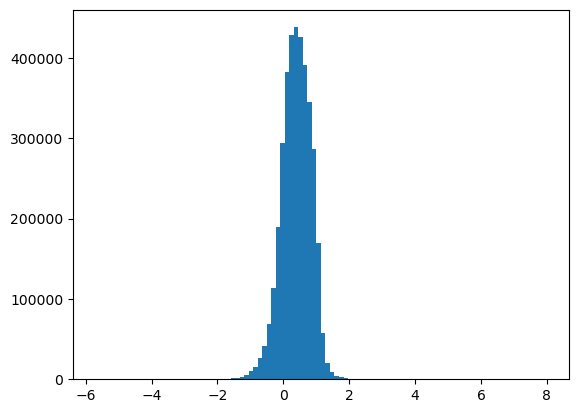

In [78]:
plt.hist(y_pred_test, bins=100)

In [75]:
A_train.data.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [ ]:
#test_recall = recall_at_k(U_final, V_final, A_test, k=10)

#print(f'Test RMSE: {test_rmse}, Test Recall@10: {test_recall}')
# Save the final user and item matrices and biases



In [ ]:
# make predictions on new data

def prepare_new_user_data(new_user_ratings, item_map):
    '''
    new_user_ratings: list of tuples of (item_id, rating)
    item_map: mapping of item_id to item index in V matrix
    '''
    item_idx = []
    ratings = []
    for item_id, rating in new_user_ratings:
        if item_id in item_map:
            item_idx.append(item_map[item_id])
            ratings.append(rating)

    # map ratings to -1,0,1
    #ratings = np.array(ratings)
    #ratings_mapped = np.where(ratings <= 4, -1,np.where(ratings <= 7, 0, 1))
    return item_idx, ratings
    


def fit_new_user(V, b_item, mu, item_idx, ratings, weights=None, reg = 1e-2 ):
    '''
    V: item latent factors matrix
    b_item: item biases
    mu: global mean
    item_idx: list of item indices rated by the new user
    ratings: list of ratings given by the new user
    weights: optional list of weights for each rating
    reg: regularization parameter

    returns: u_new (new user latent factors), b_new (new user bias)
    
    '''
    #number of items
    m = len(item_idx)
    assert m == len(ratings)
    if weights is None:
        weights = np.ones(m)
    V_i = V[item_idx]

    # remove bias
    y = ratings - mu - b_item[item_idx]

    #design matrix with bias term
    X = np.hstack([V_i, np.ones((V_i.shape[0], 1))])  

    #apply weights
    W = np.diag(weights)
    XtW = X.T @ W

    #regularization matrix (k+1)x(k+1), last regularization term is small for bias
    R = np.diag(np.r_[np.full(V.shape[1], reg), 1e-8])

    #solve for theta using ridge regression
    theta = np.linalg.solve(XtW @ X + R, XtW @ y)

    # separate user factors and bias
    u_new = theta[:-1]
    b_new = theta[-1]

    return u_new, b_new

def predict_new_user(u_new, b_new, V, b_item, mu):
    '''
    u_new: new user latent factors
    b_new: new user bias
    V: item latent factors matrix
    b_item: item biases
    mu: global mean

    returns: predicted ratings for all items
    '''
    preds = mu + b_new + b_item + V @ u_new
    return preds

#Example usage
new_user_ratings = random.sample(list(zip(usr['BGGId'], usr['Rating'])), 20)

item_idx, ratings = prepare_new_user_data(new_user_ratings, item_map)
u_new, b_new = fit_new_user(V_final, b_item_final, mu_final, item_idx, ratings, reg=1e-2)

preds = predict_new_user(u_new, b_new, V_final, b_item_final, mu_final)

# Get top 10 recommendations
top_10_items = np.argsort(-preds)[:10]
# Map back to original item IDs
inv_item_map = {v: k for k, v in item_map.items()}

In [ ]:
def fold_in_user_implicit(V, rated_items, ratings, lambda_=0.1):
    """
    Compute a new user latent vector given implicit feedback strengths.
    ratings = confidence or interaction strengths (e.g., scaled 1–10)
    """
    V_i = V[rated_items]
    r_i = ratings  # no mean or bias subtraction
    A = V_i.T @ V_i + lambda_ * np.eye(V.shape[1])
    b = V_i.T @ r_i
    u_new = np.linalg.solve(A, b)
    return u_new

# Example usage for implicit feedback
new_user_implicit_ratings = random.sample(list(zip(usr['BGGId'], usr['Rating'])), 20)
item_idx_imp, ratings_imp = prepare_new_user_data(new_user_implicit_ratings, item_map)
u_new_imp = fold_in_user_implicit(V_final, item_idx_imp, ratings_imp, lambda_=0.1)

(np.float64(-7.498336684855015), np.float64(6.691721141039264))

In [85]:
np.save('U_final.npy', U_final_implicit)
np.save('V_final.npy', V_final_implicit)

In [65]:
new_user_ratings = random.sample(list(zip(usr['BGGId'], usr['Rating'])), 20)

new_user_ratings

for user, rating in new_user_ratings:
    print(f'Item ID: {user},  Rating: {rating}')

Item ID: 224037,  Rating: 8.0
Item ID: 248562,  Rating: 9.5
Item ID: 18602,  Rating: 7.0
Item ID: 209685,  Rating: 7.0
Item ID: 173346,  Rating: 7.0
Item ID: 282033,  Rating: 9.0
Item ID: 215341,  Rating: 6.0
Item ID: 274364,  Rating: 9.0
Item ID: 41933,  Rating: 8.0
Item ID: 239188,  Rating: 8.0
Item ID: 150,  Rating: 6.0
Item ID: 137397,  Rating: 7.0
Item ID: 172503,  Rating: 7.0
Item ID: 70323,  Rating: 8.0
Item ID: 169786,  Rating: 7.5
Item ID: 12962,  Rating: 6.2
Item ID: 163930,  Rating: 5.5
Item ID: 123540,  Rating: 7.0
Item ID: 35815,  Rating: 9.0
Item ID: 692,  Rating: 6.7


In [57]:
pairs = list(zip(usr['BGGId'], usr['Rating']))
sample = random.sample(pairs, 20)

In [70]:
A_final.data

NameError: name 'A_final' is not defined

In [136]:
from pyspark.ml import ALS

ModuleNotFoundError: No module named 'pyspark'